In [101]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xesmf
from glob import glob
from utils import fix_crocotime
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

In [102]:
cluster = SLURMCluster(queue='debug', cores=16,
                       memory="32GB", walltime="04:00:00")
cluster.scale(jobs=2)
client = Client(cluster)

In [103]:
!squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             14016     debug dask-wor    lucas PD       0:00      1 (None)
             14017     debug dask-wor    lucas PD       0:00      1 (Priority)
             14005     part2 job1_ANA   ngouin  R    8:46:37      1 n010


In [104]:
path        = sorted(glob('/ceaza/lucas/storage/FORECAST/4DPHYSICSD/HINDCAST/2021*'))+sorted(glob('/ceaza/lucas/storage/FORECAST/4DPHYSICSD/HINDCAST/2022*'))
def preprocess(ds):
    ds = ds.thetao.sel(longitude=slice(-75.5,-70.5), latitude=slice(-33.7,-27.3)).isel(depth=0)
    return ds
sstmercator  = xr.open_mfdataset(path, preprocess=preprocess, parallel=True, concat_dim='time', combine='nested')
sstmercator  = sstmercator.to_dataset(name='sst').persist()
sstmercator2 = sstmercator

2023-08-10 09:21:59,289 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [105]:
path  = sorted(glob('/ceaza/lucas/storage/OSTIA/2021*'))+sorted(glob('/ceaza/lucas/storage/OSTIA/2022*'))
def preprocess(ds):
    ds = ds.sel(lon=slice(-75.5,-70.5), lat=slice(-33.7,-27.3)).analysed_sst
    return ds
ostia = xr.open_mfdataset(path, parallel=True, concat_dim='time', combine='nested', preprocess=preprocess)#.load()
ostia = ostia.reindex({'time':sstmercator.time.values}, method='nearest').to_dataset(name='sst')-273.15
ostia = ostia.persist()

In [106]:
grid = xr.open_dataset('../HINDCAST/CROCO_FILES/crococeazah_grd.nc')
crocopath = glob('/oceano/lucas_sims/CROCO/OUTPUT/HINDCASTTEST/TIDES_ERA51H/croco_avg_*.nc')
def preprocess(ds):
    ds = ds['temp'].isel(s_rho=-1)
    ds = fix_crocotime(ds, YORIG='1950-01-01 00:00:00')
    ds.coords['lon_rho'] = (ds.lon_rho+180)%360-180
    return ds
croco     = xr.open_mfdataset(crocopath, parallel=True, concat_dim='time', combine='nested', preprocess=preprocess)
control   = croco.where(grid.mask_rho==1).to_dataset(name='sst').sortby('time')
control   = control.reindex({'time':ostia.time.values}, method='nearest').persist()


In [107]:
crocopath = glob('/oceano/lucas_sims/CROCO/OUTPUT/HINDCASTTEST/NMASK3/croco_avg_Y*.nc')
def preprocess(ds):
    ds = ds['temp'].isel(s_rho=-1)
    ds = fix_crocotime(ds, YORIG='1950-01-01 00:00:00')
    ds.coords['lon_rho'] = (ds.lon_rho+180)%360-180
    return ds
croco     = xr.open_mfdataset(crocopath, parallel=True, concat_dim='time', combine='nested', preprocess=preprocess)
exp   = croco.where(grid.mask_rho==1).to_dataset(name='sst').sortby('time')
exp   = exp.reindex({'time':ostia.time.values}, method='nearest').persist()

In [108]:
reference        = ostia.copy()
husk             = xr.Dataset(coords={'lat':(['lat'], reference.lat.values, reference.lat.attrs),
                                      'lon':(['lon'], reference.lon.values, reference.lon.attrs)})
regridder = xesmf.Regridder(control.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
sst_control      = regridder(control)
sst_exp          = regridder(exp)

In [109]:
regridder   = xesmf.Regridder(sstmercator.rename({'latitude':'lat', 'longitude':'lon'}), reference, 'bilinear')
sstmercator = regridder(sstmercator2)

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('latitude', 'longitude') from data variable sst as the horizontal dimensions for the regridding.
  warnings.warn(


In [110]:
reference   = reference.compute()
sstmercator = sstmercator.compute()
sst_control = sst_control.compute()
sst_exp     = sst_exp.compute()

(-33.5, -27.4978588)

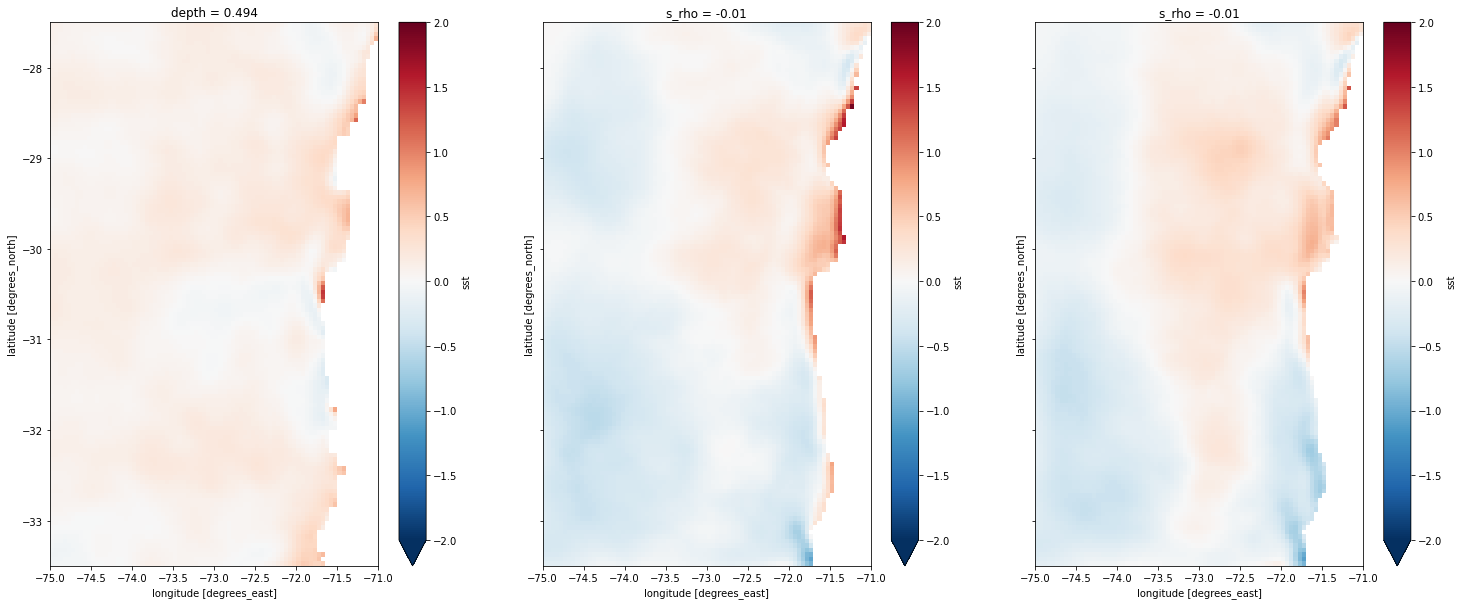

In [111]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(25,10))

(sstmercator-reference).sst.sel(time=slice('2021','2022')).mean('time').plot(ax=ax[0], vmin=-2, vmax=2, cmap='RdBu_r')
(sst_control-reference).sst.sel(time=slice('2021','2022')).mean('time').plot(ax=ax[1], vmin=-2,vmax=2, cmap='RdBu_r')
(sst_exp-reference).sst.sel(time=slice('2021','2022')).mean('time').plot(ax=ax[2], vmin=-2,vmax=2, cmap='RdBu_r')

plt.xlim(-75,-71)
plt.ylim(-33.5,-27.4978588)

(-33.5, -27.4978588)

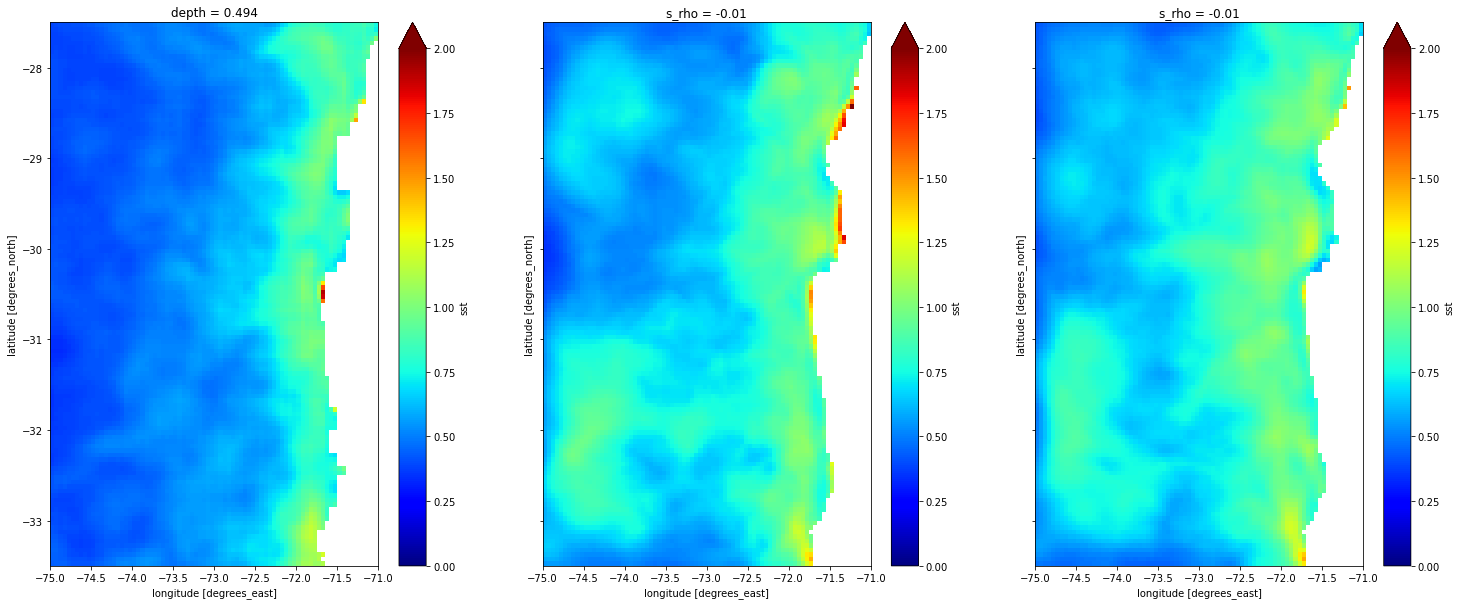

In [112]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(25,10))

(((sstmercator-reference)**2).sst.sel(time=slice('2021','2022')).mean('time')**0.5).plot(ax=ax[0], vmin=0, vmax=2, cmap='jet')
(((sst_control-reference)**2).sst.sel(time=slice('2021','2022')).mean('time')**0.5).plot(ax=ax[1], vmin=0, vmax=2, cmap='jet')
(((sst_exp-reference)**2).sst.sel(time=slice('2021','2022')).mean('time')**0.5).plot(ax=ax[2], vmin=0, vmax=2, cmap='jet')

plt.xlim(-75,-71)
plt.ylim(-33.5,-27.4978588)

(-33.5, -27.4978588)

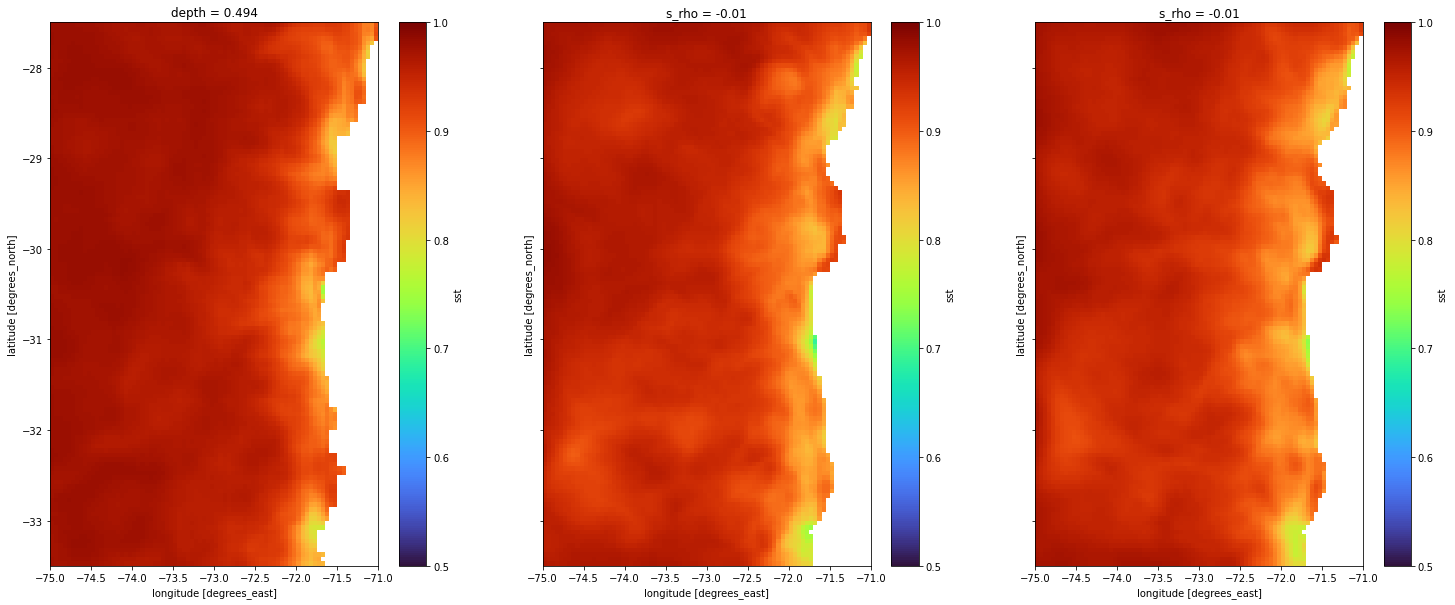

In [113]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(25,10))

xr.corr(sstmercator.sst,
        reference.sst,
        'time').plot(ax=ax[0], vmin=0.5, vmax=1, cmap='turbo')

xr.corr(sst_control.sst,
        reference.sst,
        'time').plot(ax=ax[1], vmin=0.5, vmax=1, cmap='turbo')

xr.corr(sst_exp.sst,
        reference.sst,
        'time').plot(ax=ax[2], vmin=0.5, vmax=1, cmap='turbo')


plt.xlim(-75,-71)
plt.ylim(-33.5,-27.4978588)

# (sstmercator-reference).sst.mean('time').plot(ax=ax[0], vmin=-1, vmax=1, cmap='RdBu_r')
# (sst_control-reference).sst.mean('time').plot(ax=ax[1], vmin=-1,vmax=1, cmap='RdBu_r')
# (sst_exp2-reference).sst.mean('time').plot(ax=ax[2], vmin=-1,vmax=1, cmap='RdBu_r')
# (sst_exp1-reference).sst.mean('time').plot(ax=ax[3], vmin=-1,vmax=1, cmap='RdBu_r')

(-33.5, -27.4978588)

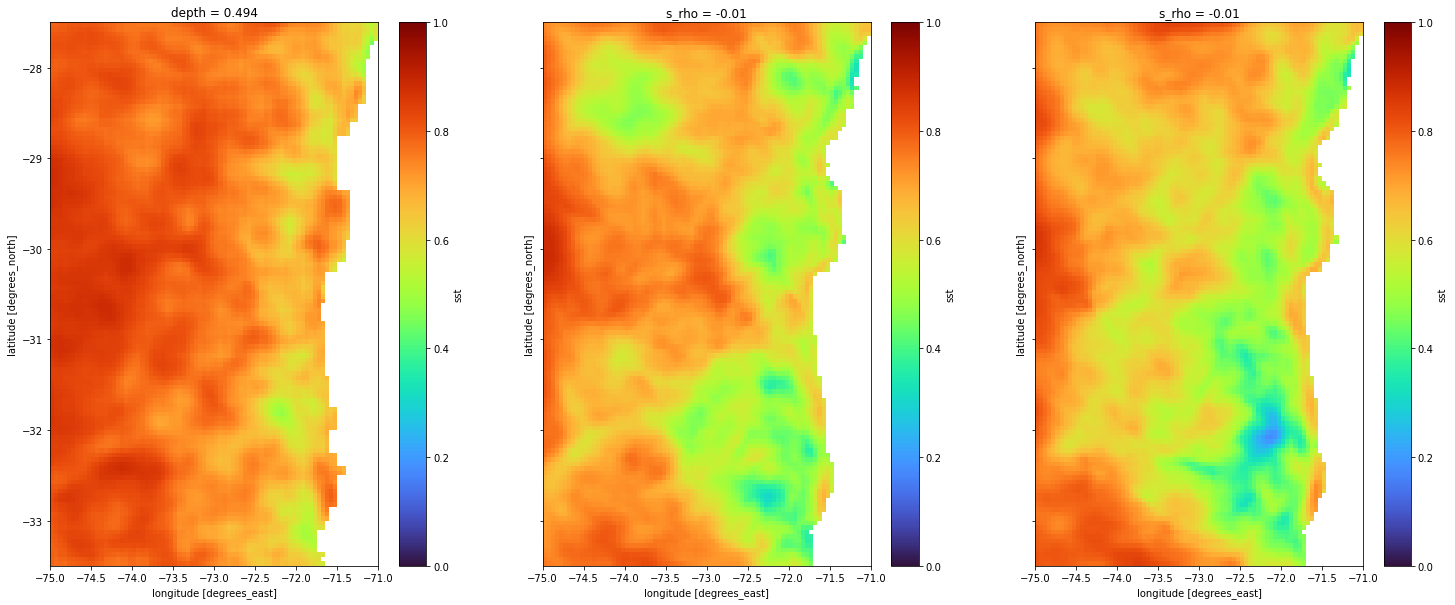

In [114]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(25,10))

xr.corr(sstmercator.sst.groupby('time.month')-sstmercator.sst.groupby('time.month').mean(),
        reference.sst.groupby('time.month')-reference.sst.groupby('time.month').mean(),
        'time').plot(ax=ax[0], vmin=0, vmax=1, cmap='turbo')

xr.corr(sst_control.sst.groupby('time.month')-sst_control.sst.groupby('time.month').mean(),
        reference.sst.groupby('time.month')-reference.sst.groupby('time.month').mean(),
        'time').plot(ax=ax[1], vmin=0, vmax=1, cmap='turbo')

xr.corr(sst_exp.sst.groupby('time.month')-sst_exp.sst.groupby('time.month').mean(),
        reference.sst.groupby('time.month')-reference.sst.groupby('time.month').mean(),
        'time').plot(ax=ax[2], vmin=0, vmax=1, cmap='turbo')

plt.xlim(-75,-71)
plt.ylim(-33.5,-27.4978588)

In [116]:
av = ((sstmercator.sst-reference.sst)**2) - ((sst_exp.sst-reference.sst)**2)
# av = av/xr.ufuncs.maximum(((sstmercator.sst-reference.sst)**2),((sst_exp.sst-reference.sst)**2))

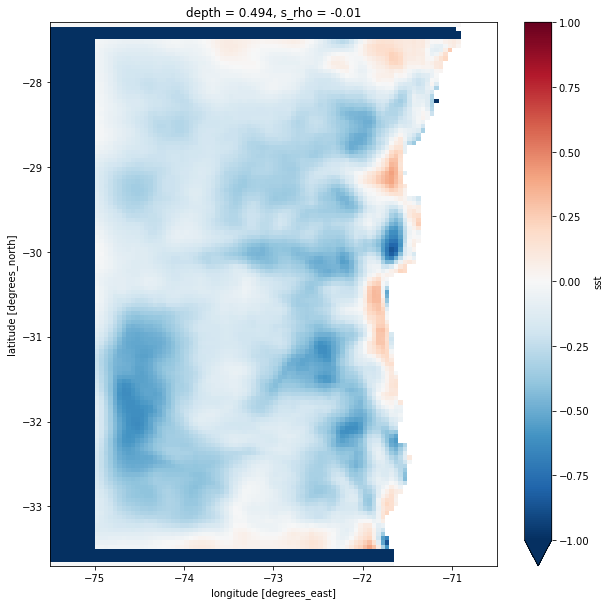

In [117]:
av.mean('time').plot(figsize=(10,10), vmin=-1,vmax=1, cmap='RdBu_r')

(18628.0, 19358.0)

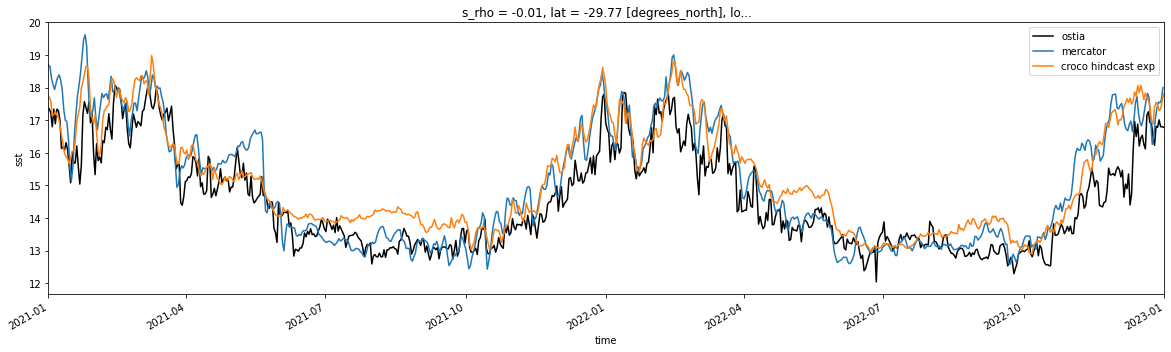

In [118]:
plt.figure(figsize=(20,5))
lat,lon = -29.8,-71.4
ostia.sst.sel(lat=lat, lon=lon, method='nearest').plot(label='ostia', color='k')
sstmercator.sst.sel(lat=lat, lon=lon, method='nearest').resample({'time':'d'}).mean().plot(label='mercator')
sst_exp.sst.sel(lat=lat, lon=lon, method='nearest').plot(label='croco hindcast exp')


plt.legend()
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))

In [119]:
BTG = pd.read_pickle('~/storage/all_dfs.pkl')['BTG']['Temperatura del Agua']
BTG = BTG.loc['2021':'2023'].resample('d').mean()
BTG = BTG.where(BTG>10)

<AxesSubplot:title={'center':'s_rho = -0.01, lat = -30.23 [degrees_north], lo...'}, xlabel='time', ylabel='sst'>

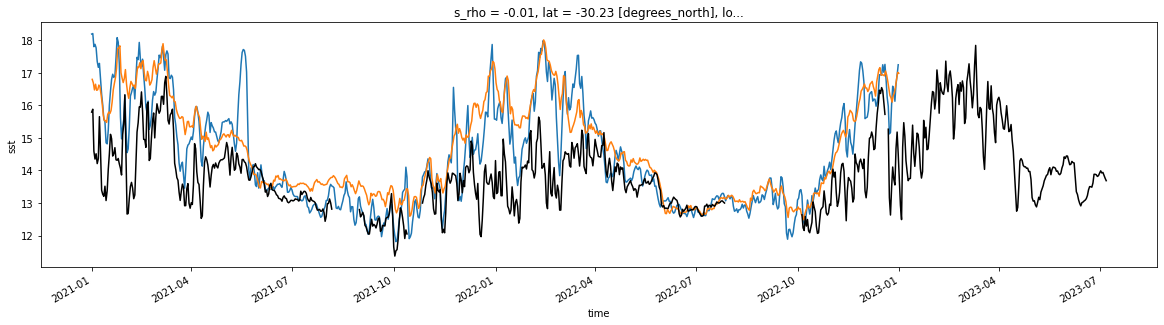

In [120]:
plt.figure(figsize=(20,5))
lat,lon = -30.25,-71.559
sstmercator.sst.sel(lat=lat, lon=lon, method='nearest').resample({'time':'d'}).mean().plot(label='mercator')
sst_exp.sst.sel(lat=lat, lon=lon, method='nearest').plot(label='croco hindcast exp')
BTG.plot(color='k')

In [123]:
client.shutdown()